In [3]:
import numpy as np
import time
import gym
import torch
import torch.nn as nn
import random
import queue
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Define Class

In [2]:
class Env():
    def __init__(self):
        self.env = gym.make('CarRacing-v0')
        self.reward_threshold = self.env.spec.reward_threshold

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()
        self.die = False
        img_rgb = self.env.reset()
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * 4
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()
        
    @staticmethod
    def rgb2gray(rgb, norm=True):
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            # normalize
            gray = gray / 128. - 1.
        return gray

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v


class Agent():
    def __init__(self):
        self.net = Net().float().to(device)

    def select_action(self, state):
        state = torch.from_numpy(state).float().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        action = alpha / (alpha + beta)

        action = action.squeeze().cpu().numpy()
        return action

    def load_param(self):
        self.net.load_state_dict(torch.load('param/expert.pkl'))
    
     
class Classifier(nn.Module):
    def __init__(self,ch=2):
        super(Classifier,self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=4,out_channels=ch*8,kernel_size=7),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*8,out_channels=ch*16,kernel_size=5,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*16,out_channels=ch*32,kernel_size=3,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*32,out_channels=ch*32,kernel_size=3,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*32,out_channels=ch*64,kernel_size=3,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*64,out_channels=ch*64,kernel_size=3,stride=2),
            torch.nn.ReLU()
        )
        self.v = torch.nn.Sequential(
            torch.nn.Linear(64*ch*1*1,256),
            torch.nn.ReLU()
        )
        self.fc = torch.nn.Linear(256,3)
        self.ch = ch
        
    def forward(self,x):
        x = self.layer1(x)
        x = x.view(x.size(0),-1)
        x = self.v(x)
        x = self.fc(x)
        
        x[:,0] = torch.tanh(x[:,0])
        x[:,1] = torch.sigmoid(x[:,1])
        x[:,2] = torch.sigmoid(x[:,2])
        return x

class ImgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index]
        return x, y

epoch 1
Track generation: 1131..1418 -> 287-tiles track
score: 1030.3999999999874
Track generation: 957..1205 -> 248-tiles track
score: 921.0028340080823
Track generation: 1248..1564 -> 316-tiles track
score: 1018.8999999999829
Track generation: 1183..1483 -> 300-tiles track
score: 898.1775919732248
Track generation: 1110..1395 -> 285-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1035..1298 -> 263-tiles track
score: 1038.2999999999938
Track generation: 1132..1419 -> 287-tiles track
score: 905.713986013971
Track generation: 1191..1493 -> 302-tiles track
score: 1025.5999999999935
Track generation: 1008..1264 -> 256-tiles track
score: 1043.0999999999876
Track generation: 1198..1502 -> 304-tiles track
score: 1023.8999999999922
Track generation: 1282..1606 -> 324-tiles track
score: 1017.099999999991
Track generation: 1241..1556 -> 315-tiles track
score: 901.6305732483862
Track generation: 1168..1464 -> 296-tiles track
score: 89

Epoch: 24
Dagger	mean: 506.93	variance: 222.51
Track generation: 980..1229 -> 249-tiles track
Epoch: 25
Dagger	mean: 518.03	variance: 224.70
Track generation: 1166..1469 -> 303-tiles track
Epoch: 26
Dagger	mean: 528.36	variance: 226.31
Track generation: 991..1250 -> 259-tiles track
Epoch: 27
Dagger	mean: 523.57	variance: 223.42
Track generation: 1100..1379 -> 279-tiles track
Epoch: 28
Dagger	mean: 534.36	variance: 226.43
Track generation: 1194..1497 -> 303-tiles track
Epoch: 29
Dagger	mean: 524.57	variance: 228.44
Track generation: 1144..1434 -> 290-tiles track
Epoch: 30
Dagger	mean: 517.06	variance: 228.21
Track generation: 1038..1309 -> 271-tiles track
Epoch: 31
Dagger	mean: 515.98	variance: 224.58
Track generation: 1015..1273 -> 258-tiles track
Epoch: 32
Dagger	mean: 525.42	variance: 227.21
Track generation: 1283..1608 -> 325-tiles track
Epoch: 33
Dagger	mean: 516.81	variance: 228.99
Track generation: 1195..1498 -> 303-tiles track
Epoch: 34
Dagger	mean: 511.30	variance: 227.81
Track

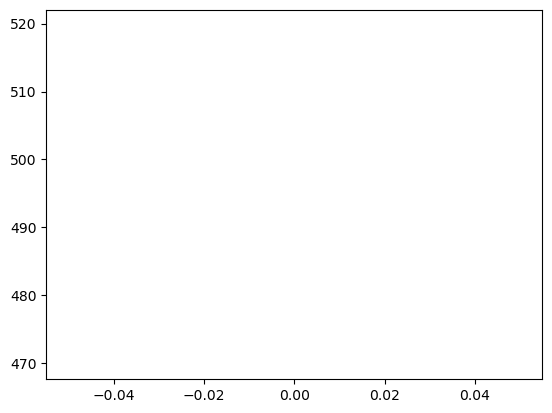

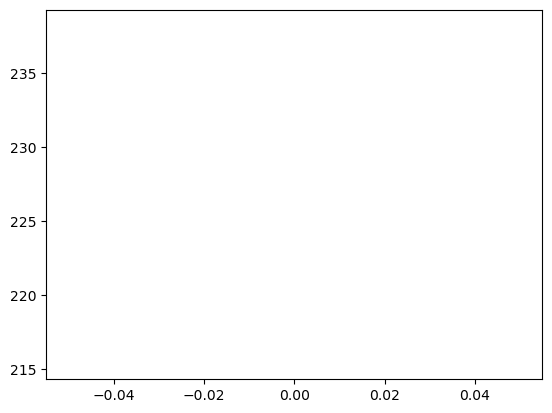

epoch 2
Track generation: 1080..1354 -> 274-tiles track
score: 903.9849816849717
Track generation: 1024..1293 -> 269-tiles track
score: 1031.8999999999883
Track generation: 1209..1515 -> 306-tiles track
score: 897.7065573770358
Track generation: 1289..1617 -> 328-tiles track
score: 892.4094801223033
Track generation: 1216..1524 -> 308-tiles track
score: 898.7706840390678
Track generation: 1168..1473 -> 305-tiles track
score: 913.1105263157757
Track generation: 1347..1688 -> 341-tiles track
score: 1012.4999999999941
Track generation: 1135..1423 -> 288-tiles track
score: 1031.8999999999896
Track generation: 1166..1462 -> 296-tiles track
score: 906.8305084745626
Track generation: 1138..1426 -> 288-tiles track
score: 877.0724738675815
Dataset size: 3859
[001/010] 1.33 sec(s) Train Loss: 0.000059 | Val loss: 0.000045
[002/010] 1.18 sec(s) Train Loss: 0.000031 | Val loss: 0.000037
[003/010] 1.17 sec(s) Train Loss: 0.000029 | Val loss: 0.000039
[004/010] 1.17 sec(s) Train Loss: 0.000027 | Val

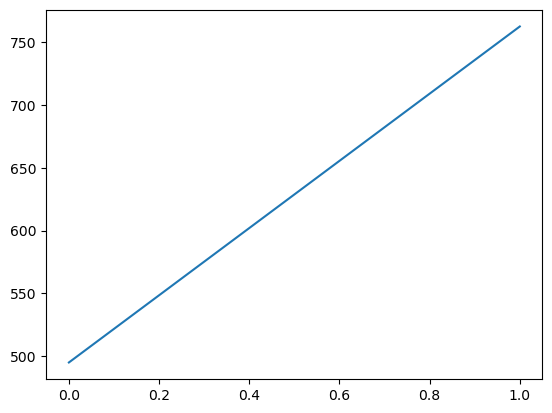

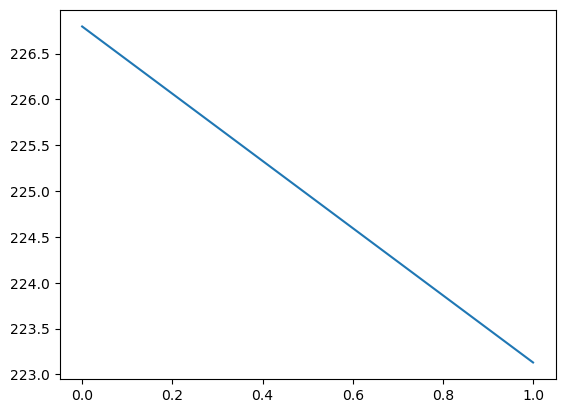

epoch 3
Track generation: 1079..1360 -> 281-tiles track
score: 897.0714285714139
Track generation: 1022..1281 -> 259-tiles track
score: 916.8720930232497
Track generation: 1049..1315 -> 266-tiles track
score: 917.9528301886704
Track generation: 1152..1451 -> 299-tiles track
score: 879.1429530201174
Track generation: 1238..1554 -> 316-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 963..1215 -> 252-tiles track
score: 514.6529880478031
Track generation: 1229..1540 -> 311-tiles track
score: 884.5693548386995
Track generation: 1189..1490 -> 301-tiles track
score: 891.2333333333215
Track generation: 1203..1508 -> 305-tiles track
score: 1020.6999999999861
Track generation: 1248..1564 -> 316-tiles track
score: 887.5777777777589
Track generation: 1200..1504 -> 304-tiles track
score: 1024.9999999999927
Dataset size: 4792
[001/010] 1.66 sec(s) Train Loss: 0.000035 | Val loss: 0.000031
[002/010] 1.46 sec(s) Train Loss: 0.000028 | Val l

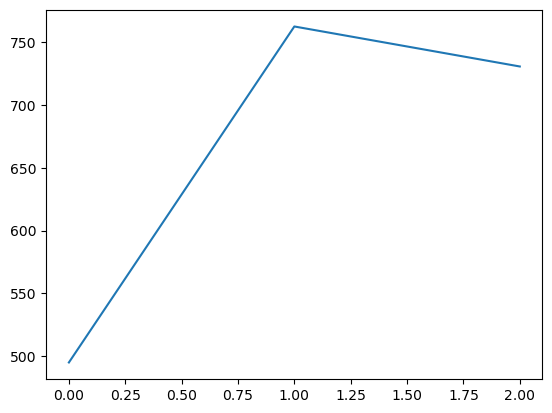

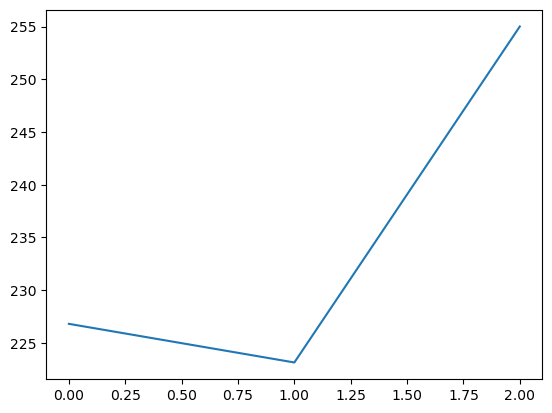

epoch 4
Track generation: 1248..1564 -> 316-tiles track
score: 898.5015873015695
Track generation: 1311..1643 -> 332-tiles track
score: 1017.899999999981
Track generation: 1140..1429 -> 289-tiles track
score: 1025.3999999999828
Track generation: 1213..1520 -> 307-tiles track
score: 908.5320261437698
Track generation: 1188..1491 -> 303-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1115..1398 -> 283-tiles track
score: 914.207801418429
Track generation: 1182..1489 -> 307-tiles track
score: 1020.7999999999823
Track generation: 1064..1334 -> 270-tiles track
score: 875.3728624535196
Track generation: 1175..1473 -> 298-tiles track
score: 904.8319865319704
Track generation: 1168..1464 -> 296-tiles track
score: 908.2203389830365
Track generation: 1142..1441 -> 299-tiles track
score: 1020.9999999999848
Dataset size: 5814
[001/010] 2.12 sec(s) Train Loss: 0.000037 | Val loss: 0.000028
[002/010] 1.76 sec(s) Train Loss: 0.000027 | Val 

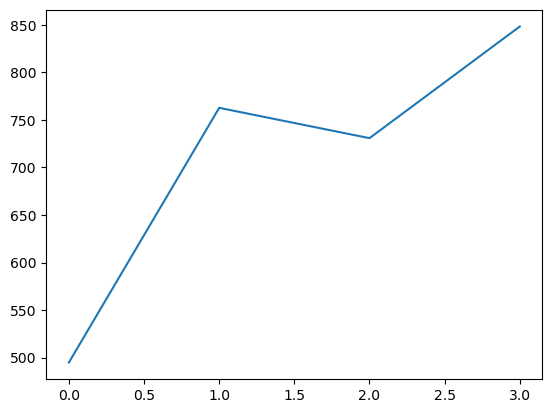

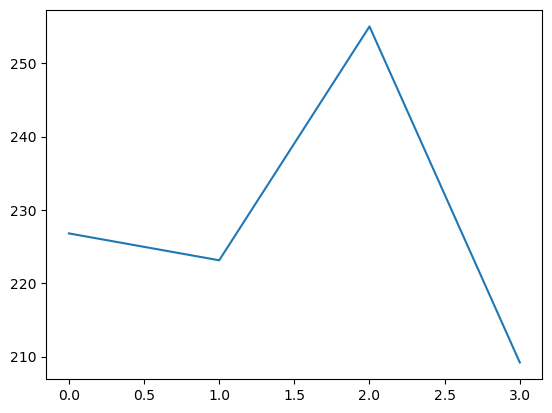

epoch 5
Track generation: 1188..1489 -> 301-tiles track
score: 1024.0999999999922
Track generation: 1111..1393 -> 282-tiles track
score: 1028.1999999999903
Track generation: 1163..1458 -> 295-tiles track
score: 903.8945578231204
Track generation: 1155..1454 -> 299-tiles track
score: 1021.6999999999847
Track generation: 1235..1548 -> 313-tiles track
score: 296.0384615384591
Track generation: 1263..1583 -> 320-tiles track
score: 877.1868338557797
Track generation: 1028..1292 -> 264-tiles track
score: 1034.1999999999848
Track generation: 1091..1371 -> 280-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1172..1469 -> 297-tiles track
score: 1020.699999999982
Track generation: 1153..1445 -> 292-tiles track
score: 1026.9999999999845
Track generation: 1058..1327 -> 269-tiles track
score: 905.443283582075
Dataset size: 6690
[001/010] 2.22 sec(s) Train Loss: 0.000039 | Val loss: 0.000030
[002/010] 2.05 sec(s) Train Loss: 0.000025 | Va

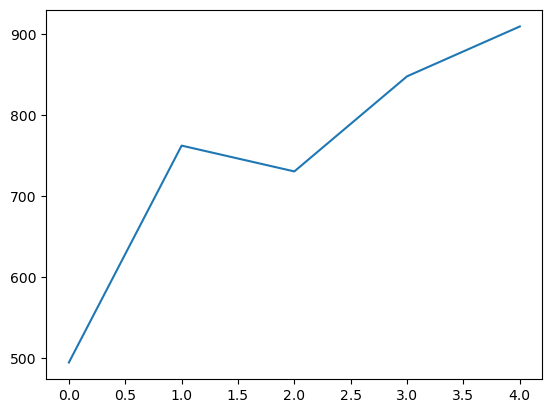

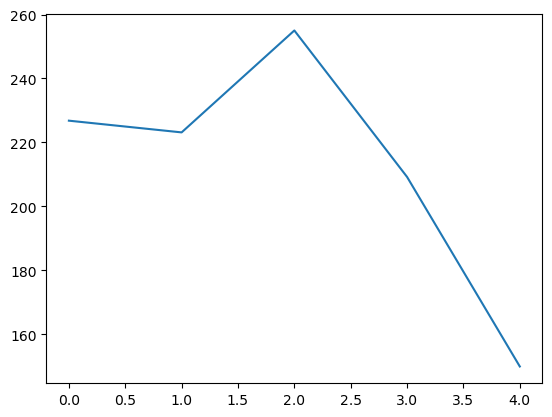

epoch 6
Track generation: 1172..1469 -> 297-tiles track
score: 902.8081081080901
Track generation: 1107..1388 -> 281-tiles track
score: 912.4571428571272
Track generation: 1024..1294 -> 270-tiles track
score: 1025.4999999999893
Track generation: 1108..1389 -> 281-tiles track
score: 1033.2999999999874
Track generation: 1246..1566 -> 320-tiles track
score: 1019.5999999999816
Track generation: 1175..1473 -> 298-tiles track
score: 1026.6999999999855
Track generation: 1364..1671 -> 307-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1072..1344 -> 272-tiles track
score: 886.1797047970374
Track generation: 1257..1575 -> 318-tiles track
score: 881.3088328075581
Track generation: 1073..1354 -> 281-tiles track
score: 1025.1999999999866
Track generation: 1100..1379 -> 279-tiles track
score: 904.2115107913504
Dataset size: 7678
[001/010] 2.65 sec(s) Train Loss: 0.000030 | Val loss: 0.000025
[002/010] 2.41 sec(s) Train Loss: 0.000025 | V

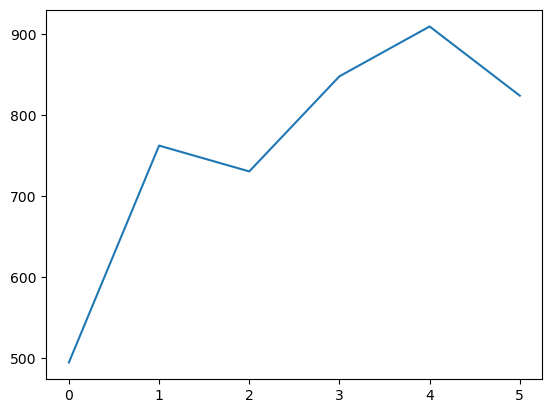

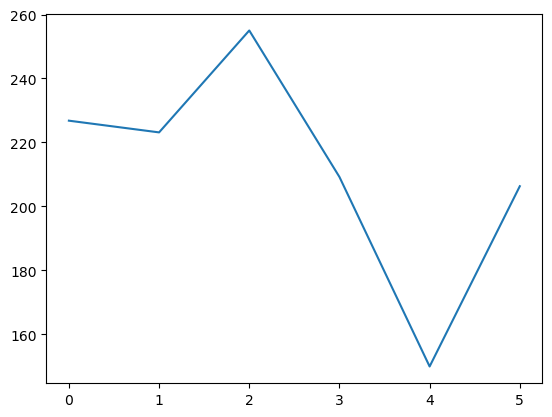

epoch 7
Track generation: 1355..1698 -> 343-tiles track
score: 944.4444444444272
Track generation: 1015..1279 -> 264-tiles track
score: 897.6840304182342
Track generation: 1282..1607 -> 325-tiles track
score: 891.4407407407194
Track generation: 1104..1384 -> 280-tiles track
score: 921.4315412186269
Track generation: 1267..1588 -> 321-tiles track
score: 887.5499999999845
Track generation: 1212..1519 -> 307-tiles track
score: 892.9281045751411
Track generation: 1159..1458 -> 299-tiles track
score: 655.7879194630763
Track generation: 1159..1453 -> 294-tiles track
score: 1024.9999999999836
Track generation: 1040..1304 -> 264-tiles track
score: 879.2726235741276
Track generation: 1016..1274 -> 258-tiles track
score: 876.2163424124417
Dataset size: 8720
[001/010] 3.07 sec(s) Train Loss: 0.000032 | Val loss: 0.000027
[002/010] 2.77 sec(s) Train Loss: 0.000025 | Val loss: 0.000026
[003/010] 2.76 sec(s) Train Loss: 0.000025 | Val loss: 0.000026
[004/010] 2.75 sec(s) Train Loss: 0.000024 | Val l

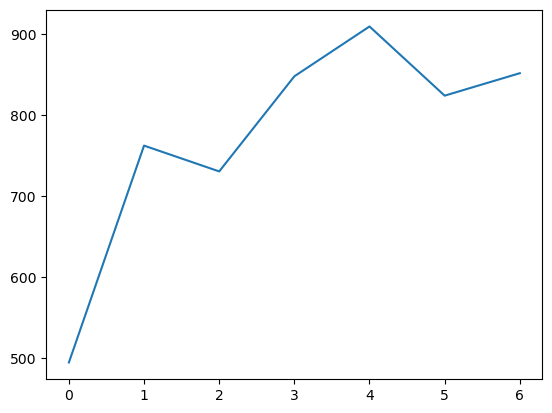

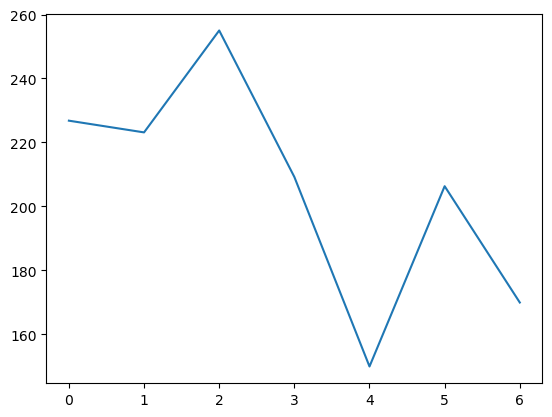

epoch 8
Track generation: 1104..1389 -> 285-tiles track
score: 1027.999999999985
Track generation: 1262..1584 -> 322-tiles track
score: 862.8168224298834
Track generation: 1180..1479 -> 299-tiles track
score: 887.2429530201184
Track generation: 1215..1523 -> 308-tiles track
score: 900.1706840390683
Track generation: 1091..1368 -> 277-tiles track
score: 1029.599999999993
Track generation: 1105..1385 -> 280-tiles track
score: 916.6473118279456
Track generation: 1176..1478 -> 302-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1162..1457 -> 295-tiles track
score: 1024.299999999993
Track generation: 1050..1316 -> 266-tiles track
score: 906.0056603773485
Track generation: 1122..1435 -> 313-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1176..1474 -> 298-tiles track
score: 890.7649831649644
Track generation: 1100..1379 -> 279-tiles track
score: 890.4787769784028
Datase

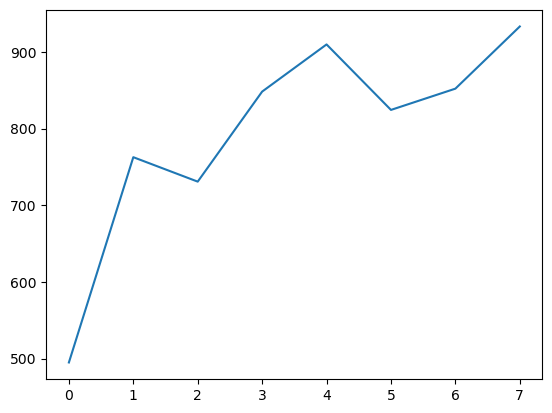

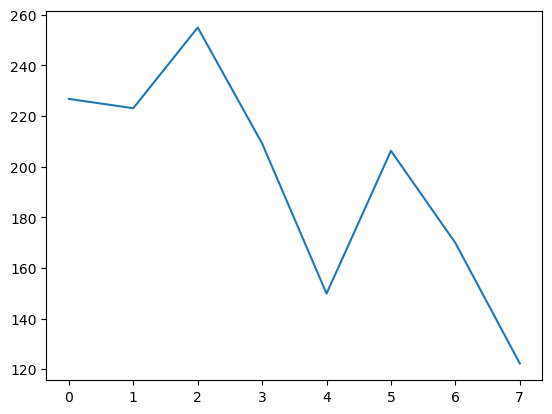

epoch 9
Track generation: 1200..1504 -> 304-tiles track
score: 1022.699999999992
Track generation: 1183..1483 -> 300-tiles track
score: 883.8996655518204
Track generation: 1117..1400 -> 283-tiles track
score: 916.2539007092087
Track generation: 1250..1566 -> 316-tiles track
score: 1020.2999999999835
Track generation: 1147..1438 -> 291-tiles track
score: 1025.4999999999868
Track generation: 1048..1308 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1084..1366 -> 282-tiles track
score: 913.3412811387782
Track generation: 1297..1625 -> 328-tiles track
score: 203.3740061162095
Track generation: 1223..1533 -> 310-tiles track
score: 899.255016181214
Track generation: 1207..1513 -> 306-tiles track
score: 1019.9999999999881
Track generation: 1237..1550 -> 313-tiles track
score: 1021.5999999999866
Dataset size: 10636
[001/010] 3.80 sec(s) Train Loss: 0.000026 | Val loss: 0.000023
[002/010] 3.66 sec(s) Train Loss: 0.000024 | Va

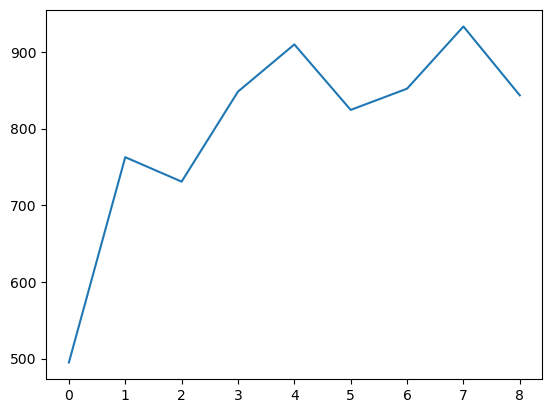

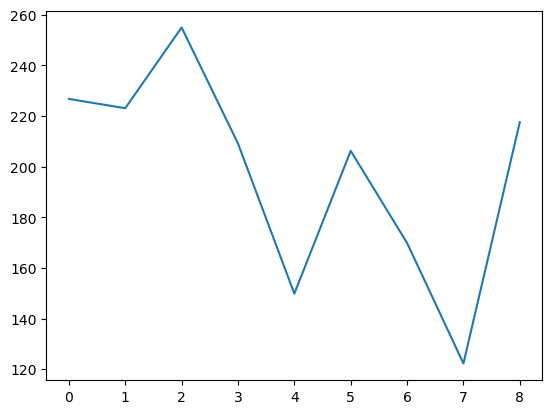

epoch 10
Track generation: 1137..1425 -> 288-tiles track
score: 903.7783972125305
Track generation: 1219..1528 -> 309-tiles track
score: 904.8064935064742
Track generation: 1095..1377 -> 282-tiles track
score: 893.8064056939372
Track generation: 1056..1324 -> 268-tiles track
score: 897.6374531835114
Track generation: 1027..1296 -> 269-tiles track
score: 780.7149253731232
Track generation: 1064..1336 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1225..1535 -> 310-tiles track
score: 1015.7999999999854
Track generation: 1092..1376 -> 284-tiles track
score: 860.5964664310802
Track generation: 1188..1489 -> 301-tiles track
score: 904.8999999999902
Track generation: 1159..1458 -> 299-tiles track
score: 887.3100671140768
Track generation: 1150..1443 -> 293-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1059..1328 -> 269-tiles track
score: 890.6492537313279
Data

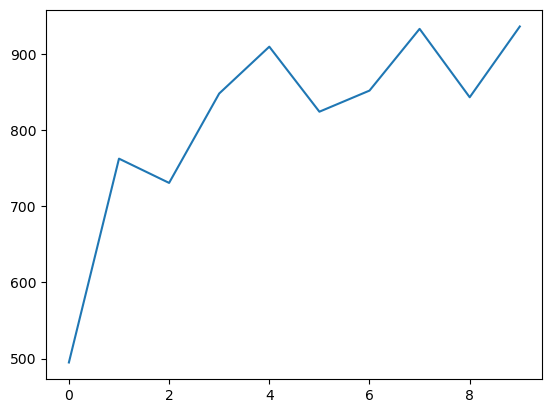

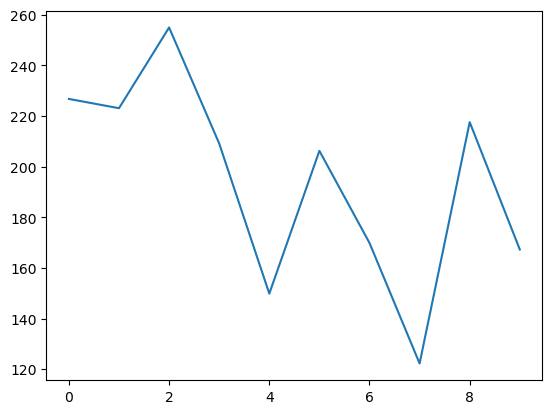

epoch 11
Track generation: 1021..1280 -> 259-tiles track
score: 878.6643410852636
Track generation: 1227..1538 -> 311-tiles track
score: 1020.3999999999925
Track generation: 1140..1435 -> 295-tiles track
score: 787.596938775502
Track generation: 1180..1479 -> 299-tiles track
score: 896.9214765100498
Track generation: 1119..1408 -> 289-tiles track
score: 900.0111111110925
Track generation: 1229..1540 -> 311-tiles track
score: 1019.8999999999922
Track generation: 1183..1492 -> 309-tiles track
score: 885.719480519461
Track generation: 1212..1519 -> 307-tiles track
score: 1020.2999999999809
Track generation: 1047..1313 -> 266-tiles track
score: 1032.7999999999931
Track generation: 1171..1466 -> 295-tiles track
score: 874.3877551020291
Dataset size: 12702
[001/010] 4.35 sec(s) Train Loss: 0.000024 | Val loss: 0.000022
[002/010] 3.96 sec(s) Train Loss: 0.000022 | Val loss: 0.000022
[003/010] 3.97 sec(s) Train Loss: 0.000021 | Val loss: 0.000023
[004/010] 3.96 sec(s) Train Loss: 0.000021 | Va

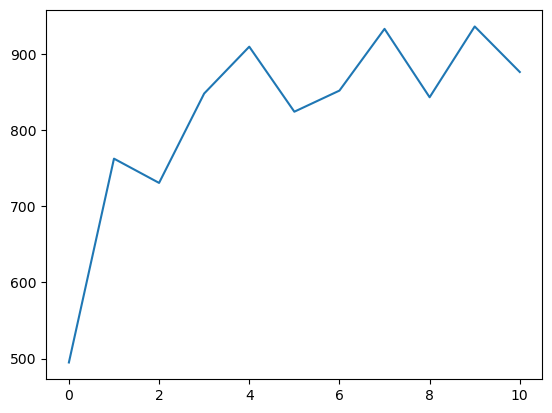

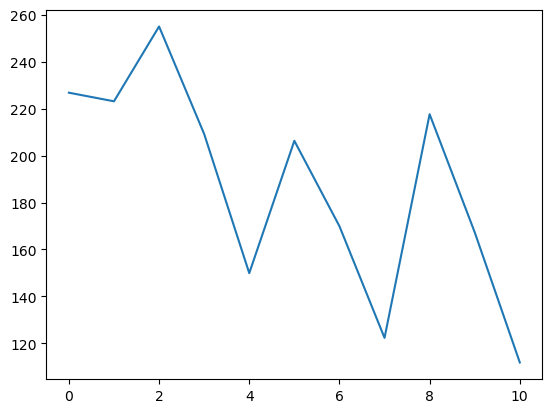

epoch 12
Track generation: 1160..1454 -> 294-tiles track
score: 884.8832764504933
Track generation: 983..1242 -> 259-tiles track
score: 1032.999999999996
Track generation: 1159..1453 -> 294-tiles track
score: 904.5610921501516
Track generation: 1081..1355 -> 274-tiles track
score: 1030.799999999992
Track generation: 1231..1543 -> 312-tiles track
score: 896.0073954983773
Track generation: 1127..1413 -> 286-tiles track
score: 900.8649122806846
Track generation: 1122..1407 -> 285-tiles track
score: 887.3887323943497
Track generation: 1484..1859 -> 375-tiles track
score: 965.2406417112103
Track generation: 1140..1429 -> 289-tiles track
score: 890.4222222222039
Track generation: 1232..1550 -> 318-tiles track
score: 858.1359621450966
Dataset size: 13747
[001/010] 4.53 sec(s) Train Loss: 0.000023 | Val loss: 0.000021
[002/010] 4.24 sec(s) Train Loss: 0.000020 | Val loss: 0.000021
[003/010] 4.24 sec(s) Train Loss: 0.000020 | Val loss: 0.000023
[004/010] 4.28 sec(s) Train Loss: 0.000020 | Val l

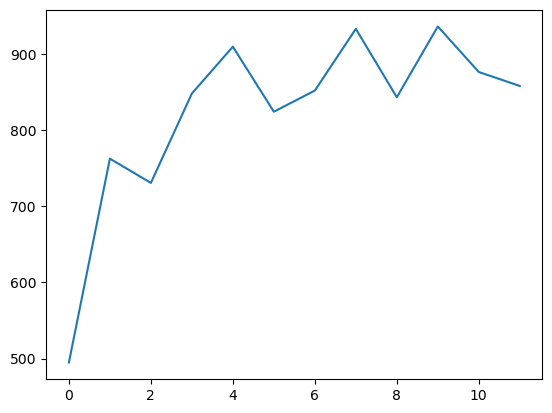

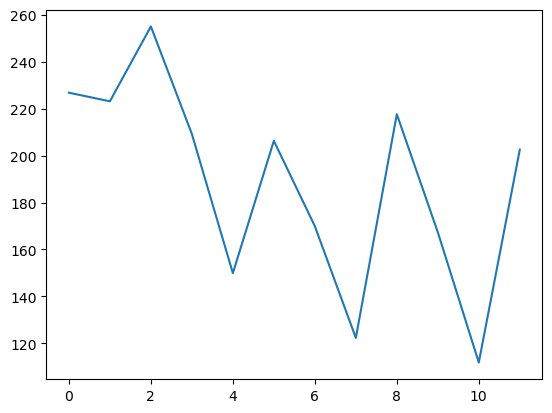

epoch 13
Track generation: 986..1244 -> 258-tiles track
score: 1035.6999999999932
Track generation: 1267..1588 -> 321-tiles track
score: 222.95000000000127
Track generation: 1062..1332 -> 270-tiles track
score: 1033.49999999999
Track generation: 1210..1526 -> 316-tiles track
score: 889.2269841269655
Track generation: 1012..1269 -> 257-tiles track
score: 904.2687499999879
Track generation: 1092..1369 -> 277-tiles track
score: 886.4449275362243
Track generation: 1296..1624 -> 328-tiles track
score: 1014.8999999999808
Track generation: 1155..1448 -> 293-tiles track
score: 702.8479452054682
Track generation: 1283..1608 -> 325-tiles track
score: 330.556790123454
Track generation: 1033..1296 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1095..1373 -> 278-tiles track
score: 884.3989169675015
Dataset size: 14512
[001/010] 4.68 sec(s) Train Loss: 0.000022 | Val loss: 0.000022
[002/010] 4.45 sec(s) Train Loss: 0.000021 | Val 

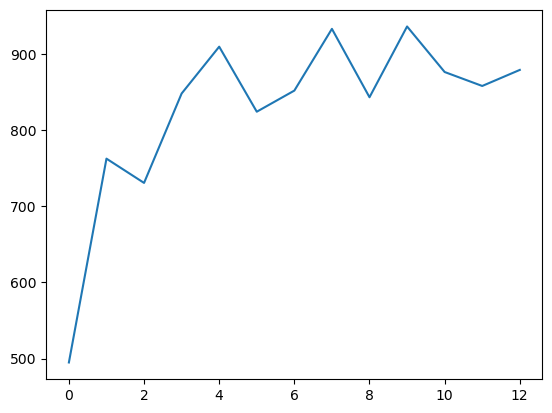

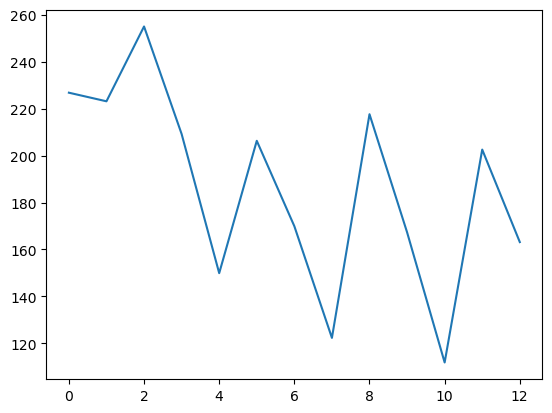

epoch 14
Track generation: 1156..1442 -> 286-tiles track
score: 887.7210526315637
Track generation: 1130..1417 -> 287-tiles track
score: 882.83496503495
Track generation: 1099..1378 -> 279-tiles track
score: 899.4230215827196
Track generation: 1311..1643 -> 332-tiles track
score: 871.6885196374399
Track generation: 1074..1350 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1202..1507 -> 305-tiles track
score: 911.2105263157744
Track generation: 1139..1428 -> 289-tiles track
score: 901.311111111092
Track generation: 1015..1274 -> 259-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1042..1307 -> 265-tiles track
score: 880.3333333333183
Track generation: 1113..1395 -> 282-tiles track
score: 1026.3999999999896
Track generation: 1134..1421 -> 287-tiles track
score: 833.1769230769077
Track generation: 1198..1502 -> 304-tiles track
score: 1030.7999999999943
Datase

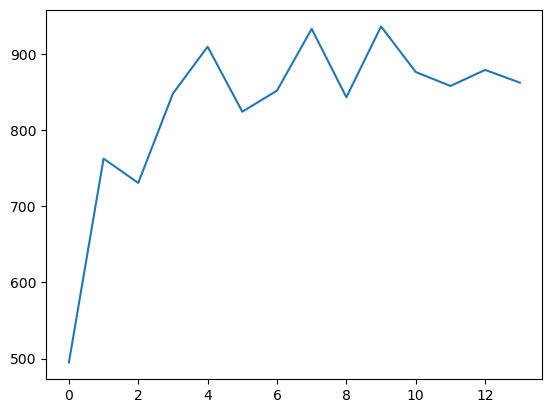

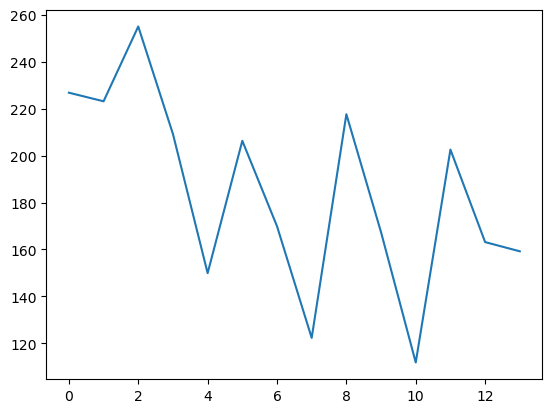

epoch 15
Track generation: 1177..1478 -> 301-tiles track
score: 923.3333333333258
Track generation: 1077..1358 -> 281-tiles track
score: 895.142857142842
Track generation: 957..1207 -> 250-tiles track
score: 894.2714859437656
Track generation: 1107..1389 -> 282-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1106..1387 -> 281-tiles track
score: 892.1999999999841
Track generation: 1240..1554 -> 314-tiles track
score: 859.1715654951938
Track generation: 1128..1414 -> 286-tiles track
score: 893.7385964912119
Track generation: 1133..1420 -> 287-tiles track
score: 1027.399999999987
Track generation: 1305..1635 -> 330-tiles track
score: 882.6234042553051
Track generation: 1087..1368 -> 281-tiles track
score: 906.6428571428434
Track generation: 1108..1389 -> 281-tiles track
score: 884.0857142856988
Dataset size: 16594
[001/010] 5.32 sec(s) Train Loss: 0.000022 | Val loss: 0.000022
[002/010] 5.12 sec(s) Train Loss: 0.000020 | Val lo

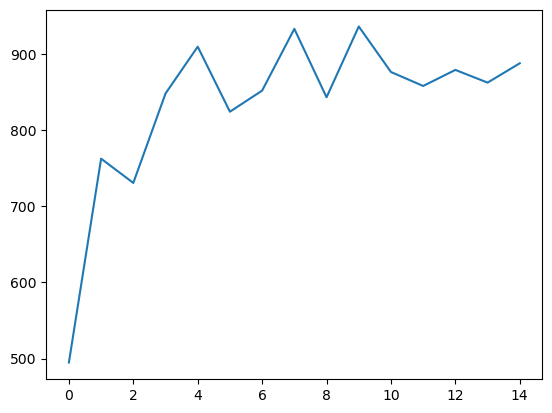

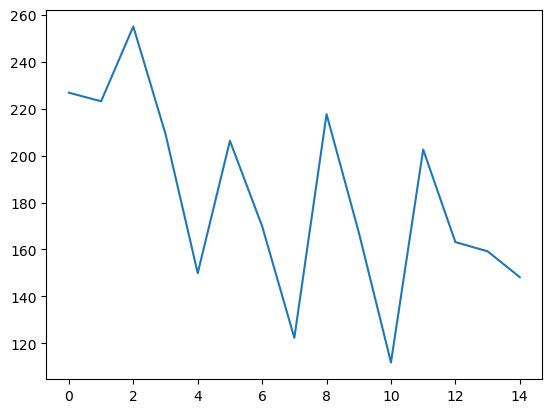

epoch 16
Track generation: 1074..1352 -> 278-tiles track
score: 886.8090252707509
Track generation: 1000..1259 -> 259-tiles track
score: 1035.799999999996
Track generation: 1175..1482 -> 307-tiles track
score: 1014.4999999999804
Track generation: 1134..1422 -> 288-tiles track
score: 907.7313588850031
Track generation: 1144..1434 -> 290-tiles track
score: 900.1989619377073
Track generation: 1123..1408 -> 285-tiles track
score: 908.6366197182928
Track generation: 946..1194 -> 248-tiles track
score: 912.5028340080808
Track generation: 1132..1419 -> 287-tiles track
score: 1026.0999999999863
Track generation: 1180..1479 -> 299-tiles track
score: 1022.7999999999846
Track generation: 1215..1531 -> 316-tiles track
score: 1011.4999999999827
Dataset size: 17596
[001/010] 6.21 sec(s) Train Loss: 0.000021 | Val loss: 0.000020
[002/010] 6.19 sec(s) Train Loss: 0.000020 | Val loss: 0.000021
[003/010] 6.09 sec(s) Train Loss: 0.000020 | Val loss: 0.000022
[004/010] 5.88 sec(s) Train Loss: 0.000020 | V

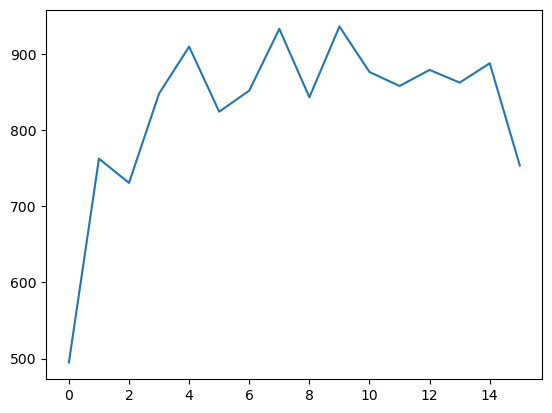

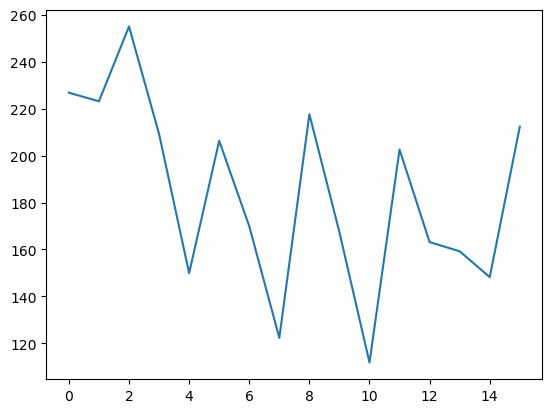

epoch 17
Track generation: 1164..1459 -> 295-tiles track
score: 843.7741496598532
Track generation: 1095..1380 -> 285-tiles track
score: 439.66549295774314
Track generation: 1157..1458 -> 301-tiles track
score: 1003.9999999999951
Track generation: 1139..1425 -> 286-tiles track
score: 863.0771929824384
Track generation: 1079..1353 -> 274-tiles track
score: 904.5849816849719
Track generation: 1163..1458 -> 295-tiles track
score: 906.9945578231217
Track generation: 1135..1430 -> 295-tiles track
score: 892.3931972789017
Track generation: 1245..1560 -> 315-tiles track
score: 250.52420382165525
Track generation: 1334..1682 -> 348-tiles track
score: 804.0345821325518
Track generation: 1012..1269 -> 257-tiles track
score: 921.6937499999881
Dataset size: 18470
[001/010] 5.96 sec(s) Train Loss: 0.000022 | Val loss: 0.000020
[002/010] 5.77 sec(s) Train Loss: 0.000020 | Val loss: 0.000022
[003/010] 5.79 sec(s) Train Loss: 0.000019 | Val loss: 0.000020
[004/010] 5.75 sec(s) Train Loss: 0.000019 | V

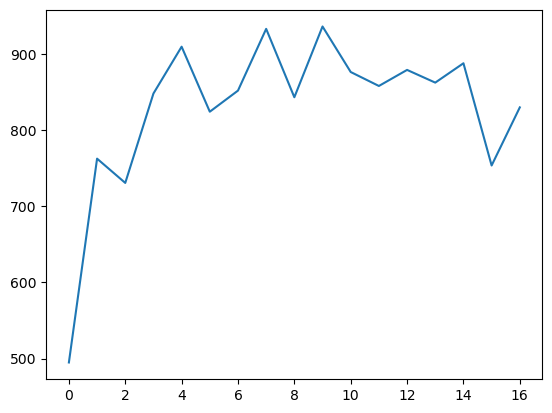

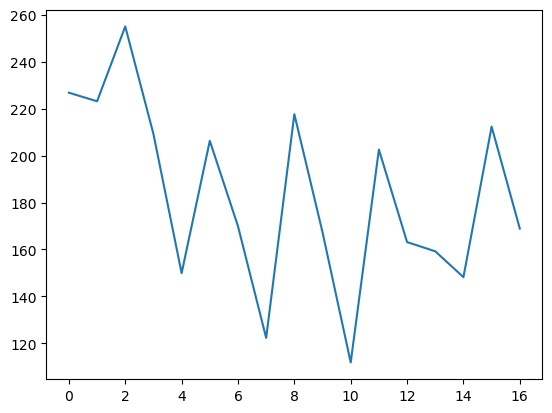

epoch 18
Track generation: 1147..1443 -> 296-tiles track
score: 1026.5999999999892
Track generation: 1226..1544 -> 318-tiles track
score: 889.2817034700178
Track generation: 1149..1440 -> 291-tiles track
score: 879.3172413792937
Track generation: 1240..1554 -> 314-tiles track
score: 900.7102236421588
Track generation: 1222..1532 -> 310-tiles track
score: 883.7462783171351
Track generation: 1274..1596 -> 322-tiles track
score: 706.7467289719474
Track generation: 1157..1455 -> 298-tiles track
score: 896.2989898989717
Track generation: 1356..1699 -> 343-tiles track
score: 1007.399999999983
Track generation: 1089..1370 -> 281-tiles track
score: 1029.6999999999873
Track generation: 1171..1468 -> 297-tiles track
score: 892.5513513513325
Dataset size: 19551
[001/010] 6.63 sec(s) Train Loss: 0.000020 | Val loss: 0.000019
[002/010] 6.12 sec(s) Train Loss: 0.000020 | Val loss: 0.000022
[003/010] 6.39 sec(s) Train Loss: 0.000019 | Val loss: 0.000023
[004/010] 6.32 sec(s) Train Loss: 0.000019 | Va

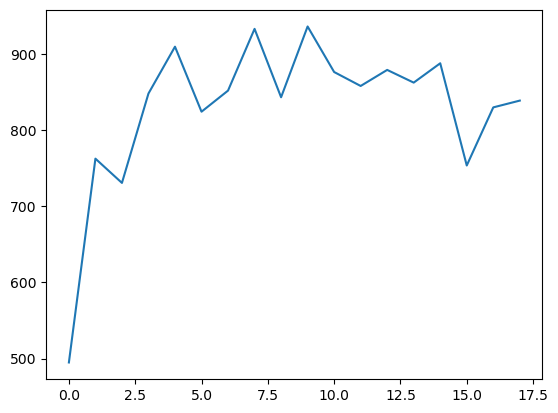

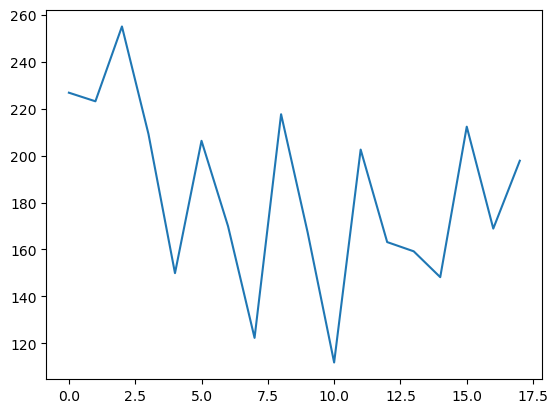

epoch 19
Track generation: 1100..1380 -> 280-tiles track
score: 875.973476702495
Track generation: 1235..1548 -> 313-tiles track
score: 899.6846153845993
Track generation: 1105..1386 -> 281-tiles track
score: 902.0428571428417
Track generation: 1015..1273 -> 258-tiles track
score: 916.2178988326748
Track generation: 1137..1427 -> 290-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1263..1583 -> 320-tiles track
score: 890.6608150470006
Track generation: 1102..1390 -> 288-tiles track
score: 904.8470383275129
Track generation: 1073..1351 -> 278-tiles track
score: 880.9989169675014
Track generation: 1118..1410 -> 292-tiles track
score: 1020.4999999999839
Track generation: 1125..1419 -> 294-tiles track
score: 890.8221843003237
Track generation: 1137..1425 -> 288-tiles track
score: 913.3156794424947
Dataset size: 20613
[001/010] 6.90 sec(s) Train Loss: 0.000020 | Val loss: 0.000019
[002/010] 6.74 sec(s) Train Loss: 0.000019 | Val 

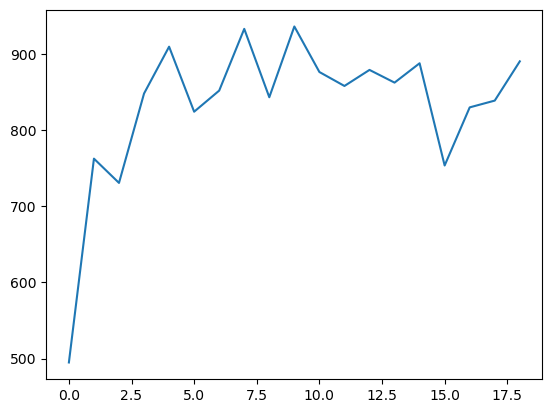

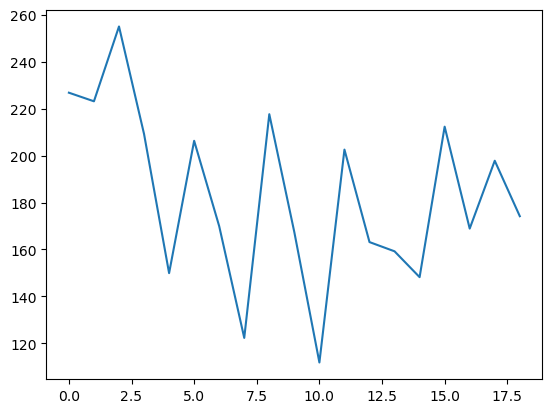

epoch 20
Track generation: 1100..1384 -> 284-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1266..1586 -> 320-tiles track
score: 869.6172413792892
Track generation: 1296..1624 -> 328-tiles track
score: 334.9792048929638
Track generation: 1007..1263 -> 256-tiles track
score: 879.0627450980227
Track generation: 1183..1484 -> 301-tiles track
score: 895.3666666666551
Track generation: 1011..1273 -> 262-tiles track
score: 1033.899999999996
Track generation: 1077..1358 -> 281-tiles track
score: 1029.1999999999873
Track generation: 1227..1538 -> 311-tiles track
score: 891.5451612903124
Track generation: 1115..1406 -> 291-tiles track
score: 907.4034482758462
Track generation: 1100..1388 -> 288-tiles track
score: 901.7783972125311
Track generation: 1215..1524 -> 309-tiles track
score: 1020.099999999983
Dataset size: 21539
[001/010] 7.04 sec(s) Train Loss: 0.000020 | Val loss: 0.000020
[002/010] 6.87 sec(s) Train Loss: 0.000019 | Val

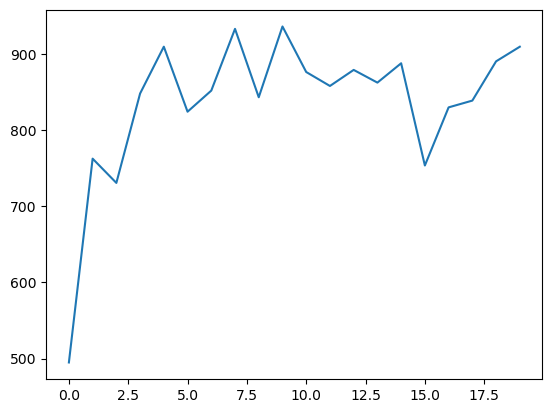

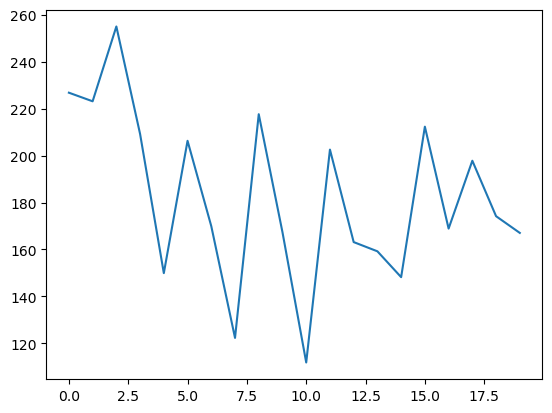

epoch 21
Track generation: 1267..1597 -> 330-tiles track
score: 425.7036474164099
Track generation: 1123..1415 -> 292-tiles track
score: 896.5178694157904
Track generation: 1061..1335 -> 274-tiles track
score: 904.8109890109781
Track generation: 1217..1525 -> 308-tiles track
score: 867.7547231270154
Track generation: 1250..1567 -> 317-tiles track
score: 1015.2999999999921
Track generation: 1157..1450 -> 293-tiles track
score: 891.4027397260104
Track generation: 1215..1523 -> 308-tiles track
score: 1027.8999999999837
Track generation: 1208..1514 -> 306-tiles track
score: 1025.0999999999892
Track generation: 1177..1476 -> 299-tiles track
score: 878.6429530201165
Track generation: 1171..1468 -> 297-tiles track
score: 890.8513513513323
Dataset size: 22476
[001/010] 7.53 sec(s) Train Loss: 0.000020 | Val loss: 0.000019
[002/010] 7.12 sec(s) Train Loss: 0.000019 | Val loss: 0.000020
[003/010] 7.09 sec(s) Train Loss: 0.000018 | Val loss: 0.000018
[004/010] 7.15 sec(s) Train Loss: 0.000019 | V

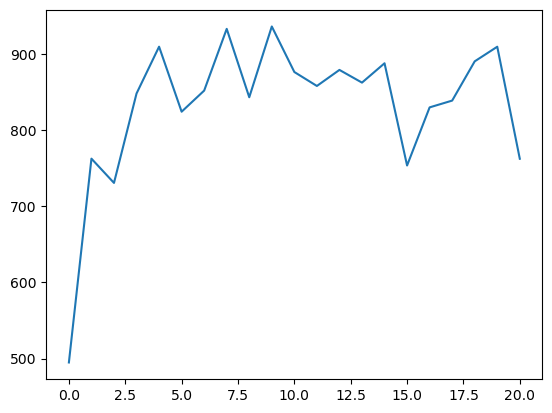

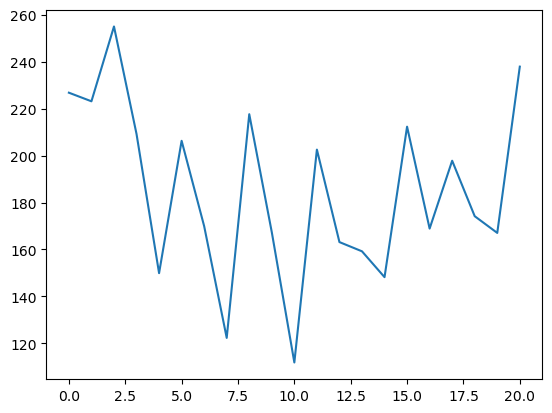

epoch 22
Track generation: 1163..1467 -> 304-tiles track
score: 874.9966996699569
Track generation: 1207..1513 -> 306-tiles track
score: 909.6213114753963
Track generation: 1303..1638 -> 335-tiles track
score: 985.0299401197412
Track generation: 1070..1341 -> 271-tiles track
score: 883.1629629629482
Track generation: 1047..1315 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1225..1536 -> 311-tiles track
score: 558.1290322580593
Track generation: 1208..1514 -> 306-tiles track
score: 359.5999999999967
Track generation: 1225..1535 -> 310-tiles track
score: 865.0288025889798
Track generation: 1044..1309 -> 265-tiles track
score: 897.9848484848338
Track generation: 1068..1339 -> 271-tiles track
score: 902.8777777777643
Track generation: 1112..1394 -> 282-tiles track
score: 1031.0999999999906
Dataset size: 23318
[001/010] 7.92 sec(s) Train Loss: 0.000019 | Val loss: 0.000019
[002/010] 7.65 sec(s) Train Loss: 0.000019 | Val

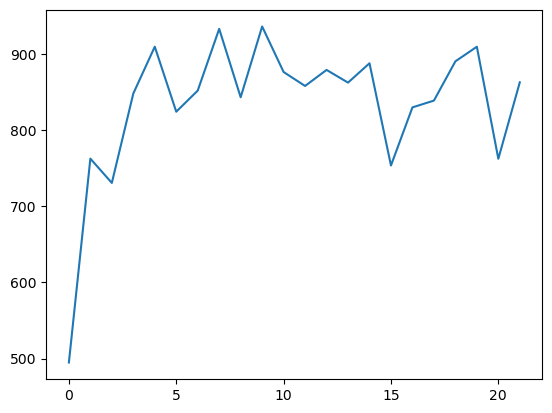

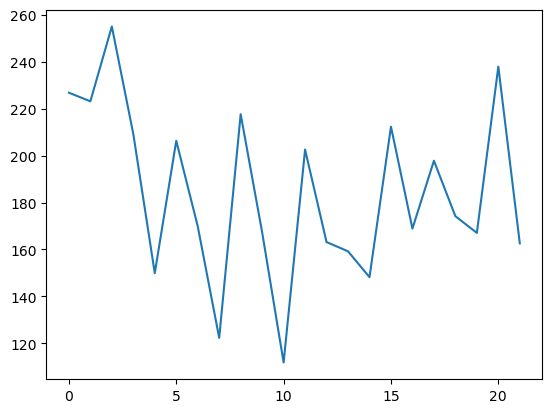

epoch 23
Track generation: 1141..1430 -> 289-tiles track
score: 678.1055555555446
Track generation: 1124..1409 -> 285-tiles track
score: 1031.2999999999852
Track generation: 1136..1424 -> 288-tiles track
score: 876.7038327526004
Track generation: 1317..1650 -> 333-tiles track
score: 963.855421686734
Track generation: 1079..1353 -> 274-tiles track
score: 914.8739926739827
Track generation: 1084..1359 -> 275-tiles track
score: 856.1065693430501
Track generation: 1204..1508 -> 304-tiles track
score: 904.1996699669853
Track generation: 1030..1298 -> 268-tiles track
score: 902.7187265917499
Track generation: 1249..1565 -> 316-tiles track
score: 892.1269841269649
Track generation: 1243..1558 -> 315-tiles track
score: 360.4280254777017
Dataset size: 24237
[001/010] 7.81 sec(s) Train Loss: 0.000020 | Val loss: 0.000019
[002/010] 7.59 sec(s) Train Loss: 0.000018 | Val loss: 0.000018
[003/010] 7.92 sec(s) Train Loss: 0.000019 | Val loss: 0.000018
[004/010] 7.79 sec(s) Train Loss: 0.000018 | Val 

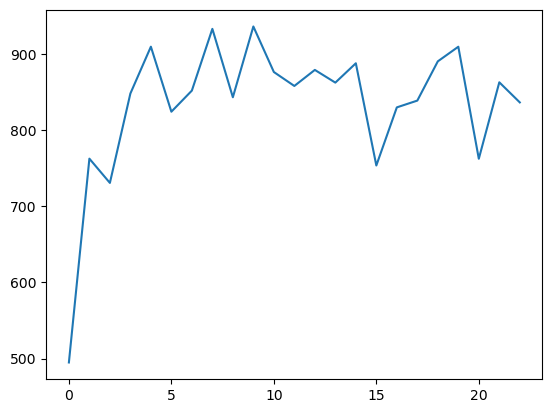

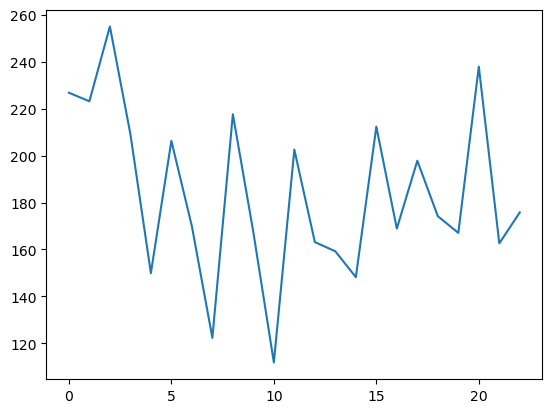

epoch 24
Track generation: 1020..1286 -> 266-tiles track
score: 898.4584905660287
Track generation: 1041..1305 -> 264-tiles track
score: 916.5931558935195
Track generation: 1240..1554 -> 314-tiles track
score: 888.2357827475912
Track generation: 1112..1394 -> 282-tiles track
score: 410.95729537366185
Track generation: 1142..1432 -> 290-tiles track
score: 1027.3999999999933
Track generation: 1066..1344 -> 278-tiles track
score: 901.6595667869967
Track generation: 1047..1313 -> 266-tiles track
score: 900.6849056603687
Track generation: 1028..1289 -> 261-tiles track
score: 869.1999999999845
Track generation: 1112..1394 -> 282-tiles track
score: 886.8302491103071
Track generation: 1144..1434 -> 290-tiles track
score: 378.3055363321753
Dataset size: 25033
[001/010] 7.67 sec(s) Train Loss: 0.000019 | Val loss: 0.000019
[002/010] 7.59 sec(s) Train Loss: 0.000018 | Val loss: 0.000019
[003/010] 7.68 sec(s) Train Loss: 0.000018 | Val loss: 0.000019
[004/010] 7.89 sec(s) Train Loss: 0.000018 | Va

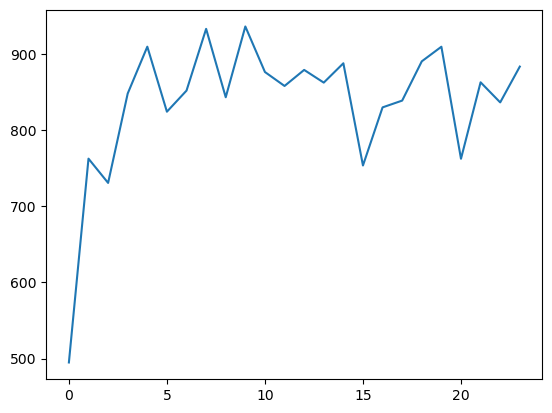

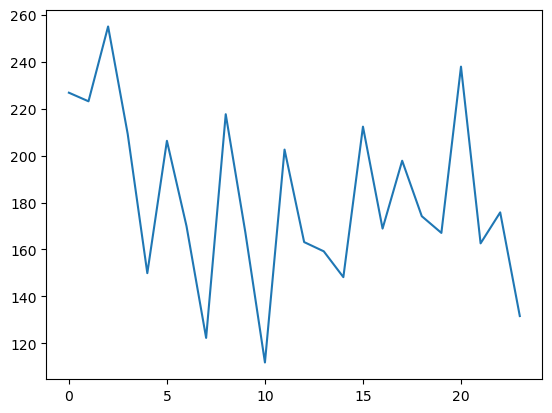

epoch 25
Track generation: 1308..1639 -> 331-tiles track
score: 1013.5999999999801
Track generation: 1071..1350 -> 279-tiles track
score: 449.5827338129451
Track generation: 1140..1429 -> 289-tiles track
score: 886.1777777777602
Track generation: 1277..1600 -> 323-tiles track
score: 356.61552795030644
Track generation: 1193..1495 -> 302-tiles track
score: 906.2554817275652
Track generation: 1275..1598 -> 323-tiles track
score: 668.6416149068184
Track generation: 1289..1616 -> 327-tiles track
score: 981.5950920245267
Track generation: 1171..1468 -> 297-tiles track
score: 893.6513513513329
Track generation: 1124..1409 -> 285-tiles track
score: 1031.5999999999851
Track generation: 1215..1522 -> 307-tiles track
score: 967.3202614378855
Dataset size: 25885
[001/010] 8.30 sec(s) Train Loss: 0.000019 | Val loss: 0.000018
[002/010] 8.15 sec(s) Train Loss: 0.000019 | Val loss: 0.000018
[003/010] 8.09 sec(s) Train Loss: 0.000018 | Val loss: 0.000018
[004/010] 8.11 sec(s) Train Loss: 0.000018 | V

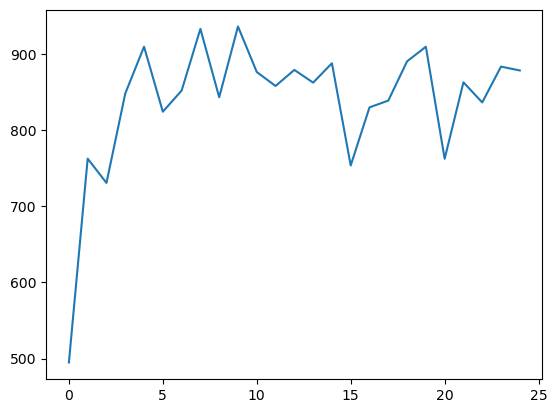

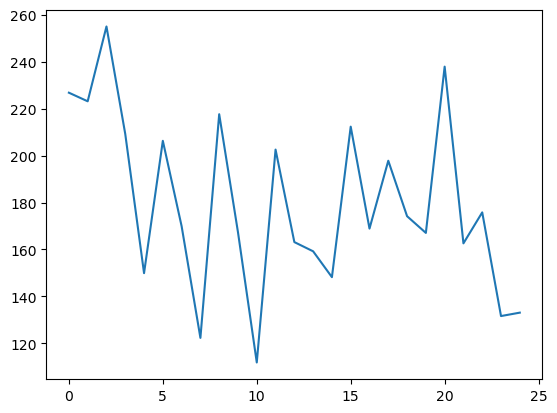

epoch 26
Track generation: 1358..1701 -> 343-tiles track
score: 660.2140350877069
Track generation: 1177..1485 -> 308-tiles track
score: 456.7433224755664
Track generation: 1075..1355 -> 280-tiles track
score: 904.6630824372638
Track generation: 955..1198 -> 243-tiles track
score: 858.1520661156947
Track generation: 1125..1410 -> 285-tiles track
score: 897.9521126760396
Track generation: 1094..1380 -> 286-tiles track
score: 910.9824561403354
Track generation: 1158..1452 -> 294-tiles track
score: 419.2027303754184
Track generation: 1270..1591 -> 321-tiles track
score: 897.9249999999848
Track generation: 1053..1320 -> 267-tiles track
score: 885.4654135338176
Track generation: 1100..1388 -> 288-tiles track
score: 906.6313588850039
Dataset size: 26709
[001/010] 8.47 sec(s) Train Loss: 0.000019 | Val loss: 0.000020
[002/010] 8.33 sec(s) Train Loss: 0.000018 | Val loss: 0.000018
[003/010] 8.37 sec(s) Train Loss: 0.000018 | Val loss: 0.000019
[004/010] 8.42 sec(s) Train Loss: 0.000018 | Val l

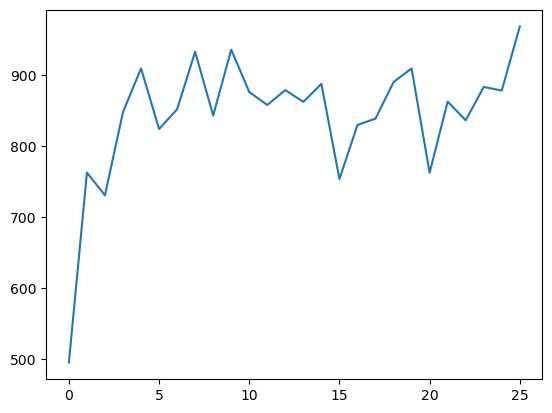

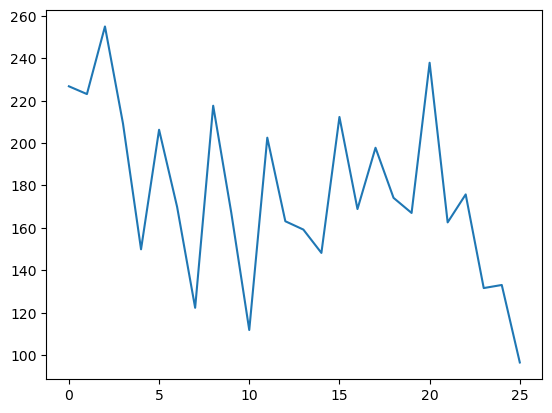

epoch 27
Track generation: 1152..1444 -> 292-tiles track
score: 1029.199999999985
Track generation: 1355..1698 -> 343-tiles track
score: 1010.899999999984
Track generation: 1348..1689 -> 341-tiles track
score: 674.8999999999921
Track generation: 1267..1588 -> 321-tiles track
score: 1014.4999999999869
Track generation: 1165..1461 -> 296-tiles track
score: 908.4203389830374
Track generation: 1020..1283 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1211..1518 -> 307-tiles track
score: 895.6601307189336
Track generation: 1207..1514 -> 307-tiles track
score: 1023.2999999999814
Track generation: 1084..1359 -> 275-tiles track
score: 1033.299999999986
Track generation: 1218..1527 -> 309-tiles track
score: 847.7116883116695
Track generation: 1144..1431 -> 287-tiles track
score: 906.7034965034794
Dataset size: 27734
[001/010] 8.82 sec(s) Train Loss: 0.000019 | Val loss: 0.000021
[002/010] 8.72 sec(s) Train Loss: 0.000018 | Va

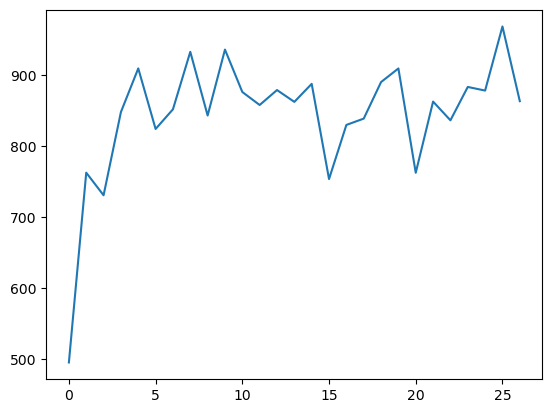

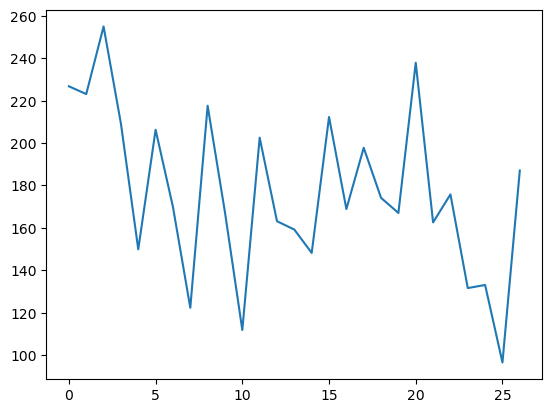

epoch 28
Track generation: 1103..1384 -> 281-tiles track
score: 889.1571428571275
Track generation: 1203..1508 -> 305-tiles track
score: 1017.999999999986
Track generation: 1210..1524 -> 314-tiles track
score: 872.6562300319357
Track generation: 1409..1765 -> 356-tiles track
score: 969.0140845070246
Track generation: 963..1215 -> 252-tiles track
score: 1038.699999999996
Track generation: 1196..1508 -> 312-tiles track
score: 890.0228295819778
Track generation: 1292..1619 -> 327-tiles track
score: 902.232515337411
Track generation: 1283..1617 -> 334-tiles track
score: 966.9669669669483
Track generation: 1217..1525 -> 308-tiles track
score: 881.6840390879287
Track generation: 1099..1378 -> 279-tiles track
score: 903.2143884891925
Dataset size: 28827
[001/010] 9.15 sec(s) Train Loss: 0.000019 | Val loss: 0.000018
[002/010] 8.97 sec(s) Train Loss: 0.000019 | Val loss: 0.000018
[003/010] 8.95 sec(s) Train Loss: 0.000018 | Val loss: 0.000019
[004/010] 9.02 sec(s) Train Loss: 0.000018 | Val lo

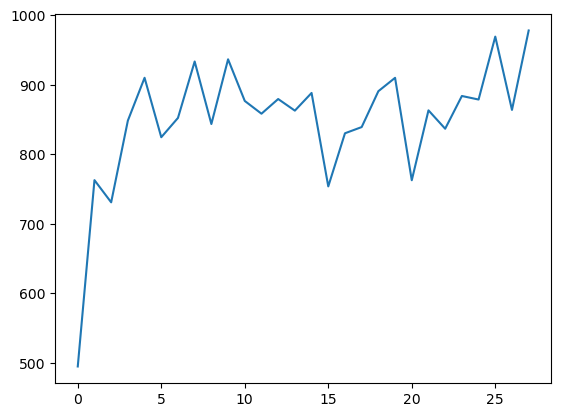

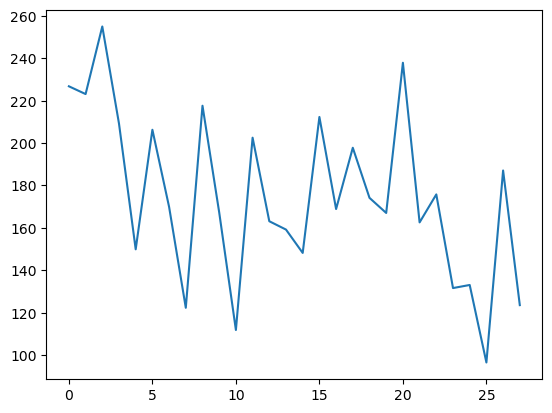

epoch 29
Track generation: 1193..1495 -> 302-tiles track
score: 1019.9999999999926
Track generation: 1144..1434 -> 290-tiles track
score: 1022.3999999999929
Track generation: 1184..1484 -> 300-tiles track
score: 888.7775919732228
Track generation: 1075..1348 -> 273-tiles track
score: 1034.6999999999857
Track generation: 1136..1424 -> 288-tiles track
score: 1026.6999999999884
Track generation: 1003..1257 -> 254-tiles track
score: 1033.799999999994
Track generation: 1073..1345 -> 272-tiles track
score: 913.4199261992527
Track generation: 1184..1484 -> 300-tiles track
score: 897.5220735785753
Track generation: 1056..1324 -> 268-tiles track
score: 1033.7999999999925
Track generation: 1140..1429 -> 289-tiles track
score: 909.1833333333151
Dataset size: 29795
[001/010] 9.51 sec(s) Train Loss: 0.000019 | Val loss: 0.000019
[002/010] 9.28 sec(s) Train Loss: 0.000018 | Val loss: 0.000021
[003/010] 9.34 sec(s) Train Loss: 0.000018 | Val loss: 0.000021
[004/010] 9.33 sec(s) Train Loss: 0.000018 |

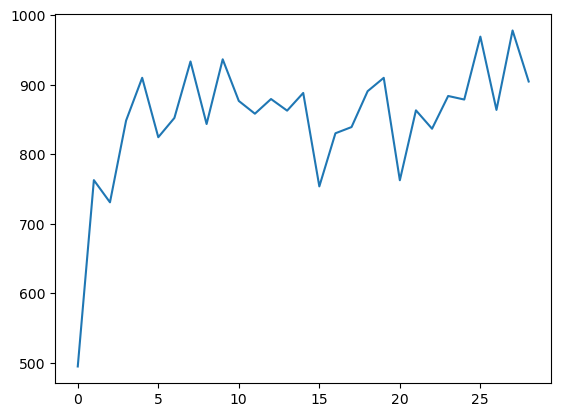

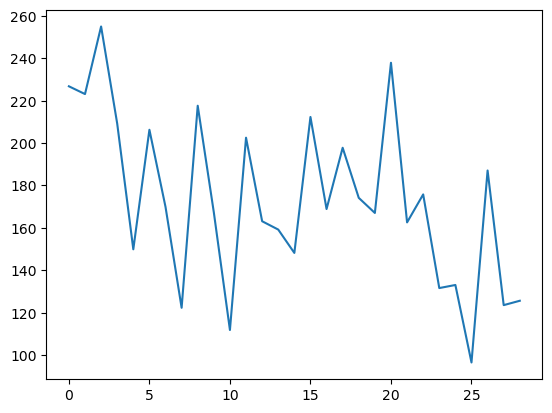

epoch 30
Track generation: 1033..1299 -> 266-tiles track
score: 660.4283018867842
Track generation: 1175..1473 -> 298-tiles track
score: 903.8319865319698
Track generation: 1060..1329 -> 269-tiles track
score: 902.211940298493
Track generation: 1006..1267 -> 261-tiles track
score: 910.0615384615238
Track generation: 1076..1349 -> 273-tiles track
score: 895.4882352941016
Track generation: 1076..1349 -> 273-tiles track
score: 868.2058823529234
Track generation: 1313..1645 -> 332-tiles track
score: 879.7308157099485
Track generation: 1164..1457 -> 293-tiles track
score: 885.7780821917637
Track generation: 1311..1644 -> 333-tiles track
score: 1011.3999999999879
Track generation: 1063..1333 -> 270-tiles track
score: 898.1951672862326
Dataset size: 30809
[001/010] 9.83 sec(s) Train Loss: 0.000019 | Val loss: 0.000018
[002/010] 9.57 sec(s) Train Loss: 0.000019 | Val loss: 0.000019
[003/010] 9.61 sec(s) Train Loss: 0.000018 | Val loss: 0.000019
[004/010] 9.65 sec(s) Train Loss: 0.000018 | Val 

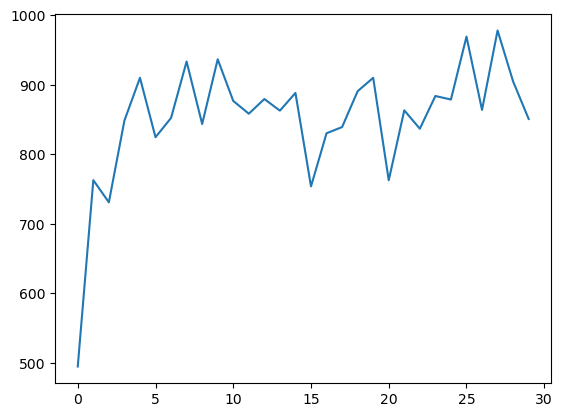

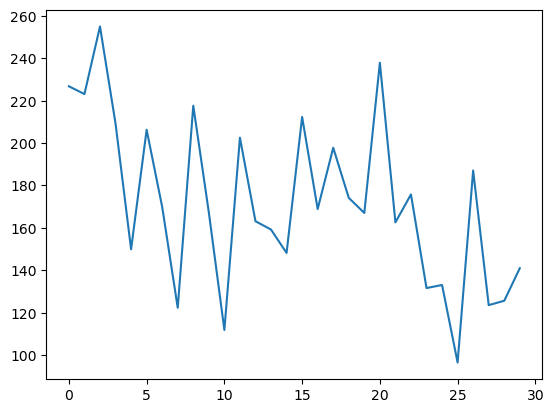

In [17]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

agent = Agent()
agent.load_param()

model = Classifier().cuda()

env = Env()

X = []
Y = []
test_mean = []
test_std = []

best_score = 0
best_std = 1e9
epoch = 30
beta = 1
p = 0.90
my_prob = list()
for i_ep in range(1, epoch+1):
    print('epoch {}'.format(i_ep))
    
    beta = math.pow(p, i_ep-1)
    my_prob = ['expert']*math.floor((beta*100)) + ['dagger']*math.floor((1-beta)*100)
    
    # get trajectory
    T = 10 if i_ep != 1 else 30
    for _ in range(T):
        score = 0
        state = env.reset()
        tmp_X, tmp_Y = [], []
        for t in range(1000):
            model_action = model(torch.tensor(state.reshape(1,4,96,96)).cuda().float())[0].cpu().detach().numpy()
            expert_action = agent.select_action(state)
            
            choice = random.choice(my_prob)
            action = model_action if choice == 'dagger' else expert_action
            
            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            tmp_X.append(state)
            tmp_Y.append(expert_action)
            
            # env.render()
            score += reward
            state = state_
            if done or die:
                break
        print("score: {}".format(score))
        
        if score > 600:
            for x in tmp_X:
                X.append(x)
            for y in tmp_Y:
                Y.append(y)
        
    env.close()
    print("Dataset size: {}".format(len(X)))
    
    # train new policy
    # model = Classifier().cuda()  
    
    seed = np.random.randint(0, 10000)
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(Y)
    
    train_x, val_x= X[:math.floor(len(X)*0.8)], X[math.floor(len(X)*0.8):]
    train_y, val_y= Y[:math.floor(len(Y)*0.8)], Y[math.floor(len(Y)*0.8):]
    batch_size = 128
    train_set = ImgDataset(train_x, train_y)
    val_set = ImgDataset(val_x, val_y)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
            
    loss = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    num_train_epoch = 10 if i_ep != 1 else 50
      
    for train_epoch in range(num_train_epoch):
        epoch_start_time = time.time()
        train_loss = 0.0
        val_loss = 0.0

        model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
        for i, data in enumerate(train_loader):
            optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
            train_pred = model(data[0].cuda().float())
            batch_loss = loss(train_pred, data[1].cuda()).cuda() # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
            batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
            optimizer.step() # 以 optimizer 用 gradient 更新參數值

            train_loss += batch_loss.item()

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                val_pred = model(data[0].cuda().float())
                batch_loss = loss(val_pred, data[1].cuda())
                val_loss += batch_loss.item()

            #將結果 print 出來
            print('[%03d/%03d] %2.2f sec(s) Train Loss: %3.6f | Val loss: %3.6f' % \
                (train_epoch + 1, num_train_epoch, time.time()-epoch_start_time, train_loss/train_set.__len__(), val_loss/val_set.__len__()))
    
    # test policy
    num_test_epoch = 50
    total_score = 0
    scores = []
    for test_epoch in range(1, num_test_epoch+1):
        score = 0
        state = env.reset()
        
        for t in range(1000):
            action = model(torch.tensor(state.reshape(1,4,96,96)).cuda().float())[0]
            action = action.cpu().detach().numpy()

            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
            # env.render()
            score += reward
            state = state_
            if done or die:
                break
    
        total_score += score
        scores.append(score)
        
        mean = np.array(scores).mean()
        std = np.array(scores).std()
        print("Epoch: {}".format(test_epoch))
        print('Dagger\tmean: {:.2f}\tvariance: {:.2f}'.format(mean, std))
    
    test_mean.append(mean)
    test_std.append(std)
    
    torch.save(model, 'dagger_model/dagger_model{}.pt'.format(i_ep))
    
    plt.figure()
    plt.plot(test_mean)
    plt.figure()
    plt.plot(test_std)
    plt.show()
        
    env.close()

In [16]:
env.close()

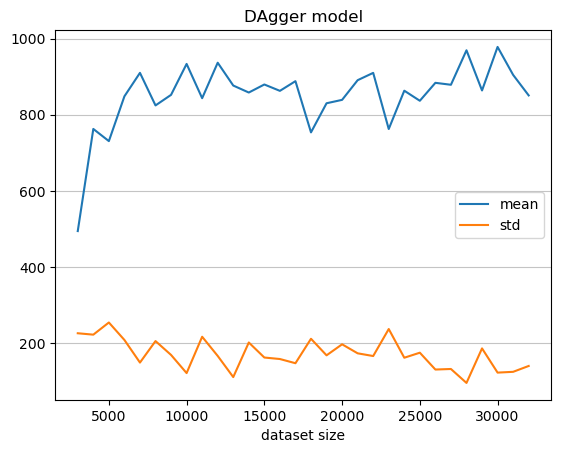

In [4]:
# np.save('./dagger_model/mean.npy', test_mean)
# np.save('./dagger_model/std.npy', test_std)

means = np.load('./dagger_model/mean.npy')
stds = np.load('./dagger_model/std.npy')

x_value = [3000+i*1000 for i in range(30)]

plt.figure()

l1 = plt.plot(x_value, means)[0]
l2 = plt.plot(x_value, stds)[0]

plt.grid(axis='y', alpha=0.75)
plt.xlabel('dataset size')
plt.title('DAgger model')
plt.legend(handles=[l1, l2], labels=['mean', 'std'])

plt.show()

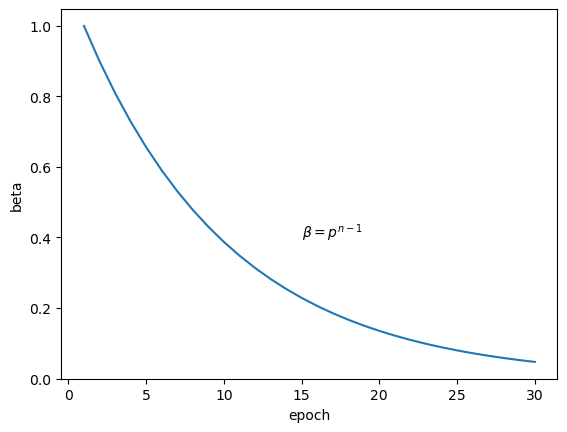

In [34]:
x_value = [i for i in range(1, 31)]
y_value = [0.9**i for i in range(30)]

plt.figure()
plt.plot(x_value, y_value)
plt.xlabel('epoch')
plt.ylabel('beta')
plt.text(15, 0.4, "$\\beta = p^{n-1}$")

plt.show()